# Mean Reversion Using IBS and RSI 

In [1]:
import numpy as np
import pandas as pd

1. IBS must be lower than 0.25 (using daily candlestick data)
2. RSI(21) must be lower than 45
3. IF 1 and 2 are true, then buy the stock
4. Exit the position when Close is higher than yesterday's Close

In [2]:
# Importing the dataset
data = pd.read_csv('./Candle_data/^NSEI-MAX.csv', index_col=0, parse_dates=True)
data = data.dropna()
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

print(data.head())
print('#' * 30)
print(data.tail())
print('#' * 30)
print(data.info())

                   Open         High          Low        Close  Volume
Date                                                                  
2007-09-17  4518.450195  4549.049805  4482.850098  4494.649902     0.0
2007-09-18  4494.100098  4551.799805  4481.549805  4546.200195     0.0
2007-09-19  4550.250000  4739.000000  4550.250000  4732.350098     0.0
2007-09-20  4734.850098  4760.850098  4721.149902  4747.549805     0.0
2007-09-21  4752.950195  4855.700195  4733.700195  4837.549805     0.0
##############################
                    Open          High           Low         Close    Volume
Date                                                                        
2023-12-04  20601.949219  20702.650391  20507.750000  20686.800781  381100.0
2023-12-05  20808.900391  20864.050781  20711.150391  20855.099609  421000.0
2023-12-06  20950.750000  20961.949219  20852.150391  20937.699219  359200.0
2023-12-07  20932.400391  20941.250000  20850.800781  20901.150391  275000.0
2023-12-08

            Market_Returns  Strategy_Returns
Date                                        
2023-12-04        1.526608          1.252309
2023-12-05        1.534711          1.260411
2023-12-06        1.538664          1.264364
2023-12-07        1.536916          1.262617
2023-12-08        1.540176          1.265877
            Market_Returns  Strategy_Returns
Date                                        
2023-12-04        4.602539          3.498410
2023-12-05        4.639983          3.526872
2023-12-06        4.658360          3.540841
2023-12-07        4.650229          3.534660
2023-12-08        4.665414          3.546202
CAGR = 8.110000000000001%
Volatility = 21.060000000000002%
Sharpe Ratio = 0.0526
Maximum Drawdown = 57.3125%


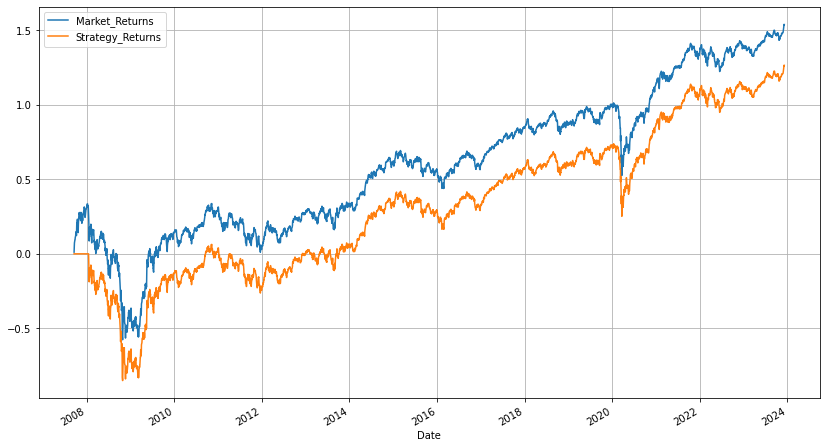

In [4]:
# Strategy rules,
# 1. IBS must be lower than 0.25 (using daily candlestick data)
# 2. RSI(21) must be lower than 45
# 3. IF 1 and 2 are true, then buy the stock
# 4. Exit the position when Close is higher than yesterday's Close

# IBS
data['IBS'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])

# RSI
data['RSI'] = data['Close'].diff()
data['RSI'] = data['RSI'].fillna(0)
data['Up'] = data['RSI'].copy()
data['Up'][data['Up'] < 0] = 0
data['Down'] = data['RSI'].copy()
data['Down'][data['Down'] > 0] = 0
data['Down'] = data['Down'].abs()
data['EMA_Up'] = data['Up'].ewm(com=13, adjust=False).mean()
data['EMA_Down'] = data['Down'].ewm(com=13, adjust=False).mean()
data['RSI'] = 100 - (100 / (1 + (data['EMA_Up'] / data['EMA_Down'])))
data = data.drop(['Up', 'Down', 'EMA_Up', 'EMA_Down'], axis=1)

# Strategy
data['Buy'] = ((data['IBS'] < 0.25) & (data['RSI'] < 45)).astype(int)
data['Sell'] = (data['Close'] > data['Close'].shift(1)).astype(int)
data['Buy'] = data['Buy'].replace(0, np.nan)
data['Sell'] = data['Sell'].replace(0, np.nan)
data['Buy'] = data['Buy'].ffill()
data['Sell'] = data['Sell'].ffill()
data['Buy'] = data['Buy'].fillna(0)
data['Sell'] = data['Sell'].fillna(0)

# Backtesting
data['Market_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['Strategy_Returns'] = data['Market_Returns'] * data['Buy'].shift(1)
data[['Market_Returns', 'Strategy_Returns']].cumsum().plot(grid=True, figsize=(14, 8))
print(data[['Market_Returns', 'Strategy_Returns']].cumsum().tail())

# Performance
data['Market_Returns'] = data['Market_Returns'].cumsum().apply(np.exp)
data['Strategy_Returns'] = data['Strategy_Returns'].cumsum().apply(np.exp)
print(data[['Market_Returns', 'Strategy_Returns']].tail())

# Performance metrics
# CAGR
days = (data.index[-1] - data.index[0]).days
cagr = ((((data['Strategy_Returns'][-1]) / data['Strategy_Returns'][1])) ** (365.0 / days)) - 1
print('CAGR =', str(round(cagr, 4) * 100) + '%')

# Volatility
data['Returns'] = data['Strategy_Returns'].pct_change()
vol = data['Returns'].std() * np.sqrt(252)
print('Volatility =', str(round(vol, 4) * 100) + '%')

# Sharpe ratio
sr = (cagr - 0.07) / vol
print('Sharpe Ratio =', round(sr, 4))

# Maximum drawdown
data['Wealth_Index'] = data['Strategy_Returns'].cummax()
data['Previous_Peak'] = data['Strategy_Returns'].cummax().shift(1)
data['Drawdown'] = (data['Previous_Peak'] - data['Strategy_Returns']) / data['Previous_Peak']
print('Maximum Drawdown =', str(round(data['Drawdown'].max() * 100, 4)) + '%')

# Plot portfolio wealth
# data['Strategy_Returns'].plot(grid=True, figsize=(14, 8))


<AxesSubplot:xlabel='Date'>

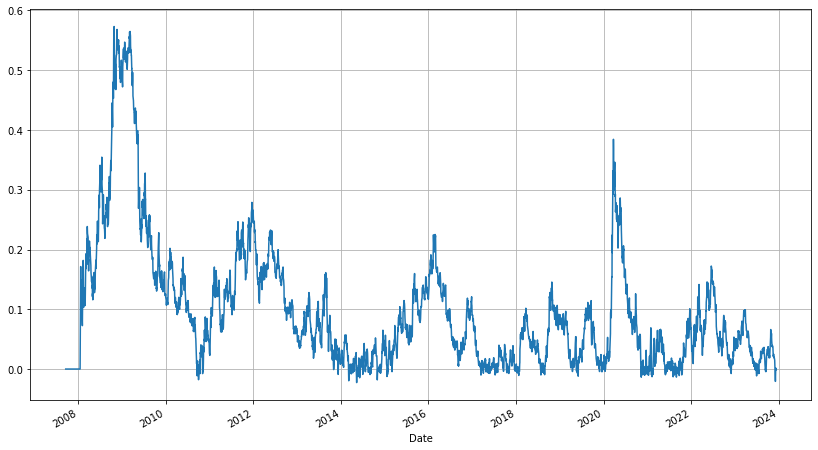

In [5]:
# Plot portfolio drawdown
data['Drawdown'].plot(grid=True, figsize=(14, 8))


<AxesSubplot:xlabel='Date'>

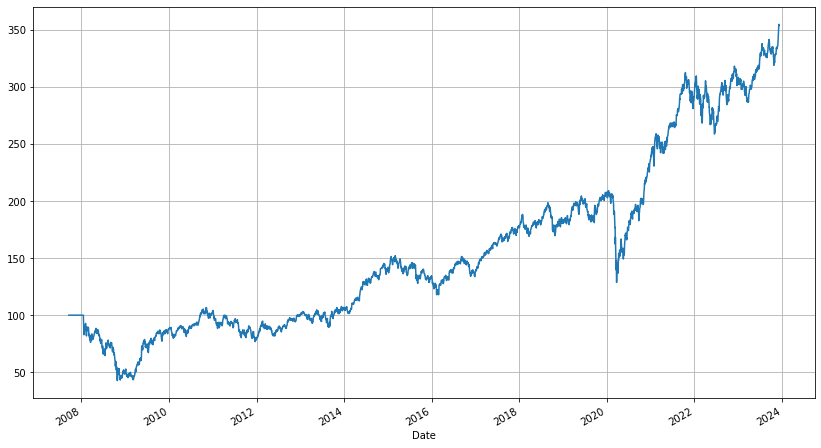

In [6]:
# Plot portfolio equity curve if we had invested $100
data['Equity_Curve'] = 100 * data['Strategy_Returns']
data['Equity_Curve'].plot(grid=True, figsize=(14, 8))
